# Linear Regression Analysis and Prediction for IoT

This notebook holds the Assignment 3.1 for Module 3 in AAI 530, Data Analytics and the Internet of Things. In this assignment, you will use linear regression to make predictions for simulated "streaming" data. The work that you do in this assignment will build on the linear regression predictions that you saw in your text book and in this week's lab session. Be sure to answer the analysis questions thoroughly, as this is a large part of the assignment for this week.

## General Assignment Instructions

These instructions are included in every assignment, to remind you of the coding standards for the class. Feel free to delete this cell after reading it. 

One sign of mature code is conforming to a style guide. We recommend the [Google Python Style Guide](https://google.github.io/styleguide/pyguide.html). If you use a different style guide, please include a cell with a link. 

Your code should be relatively easy-to-read, sensibly commented, and clean. Writing code is a messy process, so please be sure to edit your final submission. Remove any cells that are not needed or parts of cells that contain unnecessary code. Remove inessential `import` statements and make sure that all such statements are moved into the designated cell. 

When you save your notebook as a pdf, make sure that all cell output is visible (even error messages) as this will aid your instructor in grading your work.

Make use of non-code cells for written commentary. These cells should be grammatical and clearly written. In some of these cells you will have questions to answer. The questions will be marked by a "Q:" and will have a corresponding "A:" spot for you. *Make sure to answer every question marked with a `Q:` for full credit.* 

In [289]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

#suppress scientific notation in pandas
pd.set_option('display.float_format', lambda x: '%.5f' % x)

## Load and prepare your data

We'll be using the cleaned household electric consumption dataset from Module 2 in this assignment. I recommend saving your dataset by running df.to_csv("filename") at the end of the last assignment so that you don't have to re-do your cleaning steps. If you are not confident in your own cleaning steps, you may ask your instructor for a cleaned version of the data. You will not be graded on the cleaning steps in this assignment, but some functions may not work if you use the raw data.

We need to turn our datetime column into a numeric value to be used as a variable in our linear regression. In the lab session, we created a new column of minutes and just incremented the value by 10 since we knew that the readings occurred every 10 minutes. In this dataset, we have readings every minute, but we might have some missing rows depending on how you cleaned your data. So instead we will convert our datetime column to something called [unix/epoch time](https://en.wikipedia.org/wiki/Unix_time), which is the number of seconds since midnight on 1/1/1970.

**TODO: load your data and convert the datetime column into epoch/unix time**

In [319]:
import pandas as pd

# Load the data from the csv file
df = pd.read_csv("household_power_clean.csv")
df.head()

,Unnamed: 0,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,Datetime,gap_monthly,grp_monthly,v_monthly,gi_monthly
0,0,2006-12-16,17:24:00,4.21600,0.41800,234.84000,18.40000,0.00000,1.00000,17.00000,2006-12-16 17:24:00,NaN,NaN,NaN,NaN
1,1,2006-12-16,17:25:00,5.36000,0.43600,233.63000,23.00000,0.00000,1.00000,16.00000,2006-12-16 17:25:00,NaN,NaN,NaN,NaN
2,2,2006-12-16,17:26:00,5.37400,0.49800,233.29000,23.00000,0.00000,2.00000,17.00000,2006-12-16 17:26:00,NaN,NaN,NaN,NaN
3,3,2006-12-16,17:27:00,5.38800,0.50200,233.74000,23.00000,0.00000,1.00000,17.00000,2006-12-16 17:27:00,NaN,NaN,NaN,NaN
4,4,2006-12-16,17:28:00,3.66600,0.52800,235.68000,15.80000,0.00000,1.00000,17.00000,2006-12-16 17:28:00,NaN,NaN,NaN,NaN


In [320]:
# Convert the datetime column to epoch/unix time
df['Datetime'] = pd.to_datetime(df['Datetime'])
df['unix'] = (df['Datetime'] - pd.Timestamp('1970-01-01')) // pd.Timedelta('1s')

# Check the result
df.head()


,Unnamed: 0,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,Datetime,gap_monthly,grp_monthly,v_monthly,gi_monthly,unix
0,0,2006-12-16,17:24:00,4.21600,0.41800,234.84000,18.40000,0.00000,1.00000,17.00000,2006-12-16 17:24:00,NaN,NaN,NaN,NaN,1166289840
1,1,2006-12-16,17:25:00,5.36000,0.43600,233.63000,23.00000,0.00000,1.00000,16.00000,2006-12-16 17:25:00,NaN,NaN,NaN,NaN,1166289900
2,2,2006-12-16,17:26:00,5.37400,0.49800,233.29000,23.00000,0.00000,2.00000,17.00000,2006-12-16 17:26:00,NaN,NaN,NaN,NaN,1166289960
3,3,2006-12-16,17:27:00,5.38800,0.50200,233.74000,23.00000,0.00000,1.00000,17.00000,2006-12-16 17:27:00,NaN,NaN,NaN,NaN,1166290020
4,4,2006-12-16,17:28:00,3.66600,0.52800,235.68000,15.80000,0.00000,1.00000,17.00000,2006-12-16 17:28:00,NaN,NaN,NaN,NaN,1166290080


## Predicting Global Active Power

We will follow the code from the Chapter 10 in our textbook and the recorded lab session from this week to predict the Global Active Power (GAP) with linear regression.

First we will create our x (time) and y (GAP) training variables, and then define our model parameters.

**Q: What is ph? What is mu?**

A: 
**ph:** The prediction horizon, or how many timesteps ahead we want to predict, which the model is trying to predict the target variable.

**mu:** The momentum parameter used in the optimization algorithm. It controls how much the previous update direction affects the current update direction.

**TODO: Set the ph to be 5 minutes--consider the units that our time column is measured in.**

In [321]:
ts = pd.DataFrame(df.unix)
ys = pd.DataFrame(df.Global_active_power)

ph = 5 #5 minutes
ph_index = int(ph/60)#ph/data resolution (how many timesteps is our ph?)
mu = 0.9

#let's limit the number of samples in our model to 5000 just for speed
n_s = 5000

# Arrays to hold predicted values
tp_pred = np.zeros(n_s-1) 
yp_pred = np.zeros(n_s-1)

**Q: With mu = 0.9, how much weight will our first data point have on the last (5000th) prediction in our limited dataset?**

A:The weight of the first data point on the last prediction can be calculated using the following formula:

w = mu^(n-1)

where n is the number of timesteps between the first data point and the last prediction. In this case, **n-1 = 4999** (since we're only using 5000 samples in our model)and **mu = 0.9**, so:

w = 0.9^(4999) 

**TODO: Following the code from Chapter 10 and the lab session, use linear regression to predict a rolling GAP for our dataset. Store these predictions in the tp_pred and yp_pred lists created above for visualization.**

In [322]:
# At every iteration of the for loop a new data sample is acquired
for i in range(2, n_s+1):# start out with 2 leading datapoints
    #get x and y data "available" for our prediction
    ts_tmp = ts[0:i]
    ys_tmp = ys[0:i]
    ns = len(ys_tmp)
    
    weights = np.ones(ns)*mu
    for k in range(ns):
        #adjust weights to be downweighted according to their timestep away from our prediction
        weights[k] = weights[k]**k
    weights = np.flip(weights, 0)
        
    #perform linear regression on "available" data using the mu-adjusted weights
    lm_tmp = LinearRegression()
    model_tmp = lm_tmp.fit(ts_tmp, ys_tmp, sample_weight=weights)

    #store model coefficients and intercepts to compute prediction
    m_tmp = model_tmp.coef_
    q_tmp = model_tmp.intercept_

    #use ph to make the model prediction according to the prediction time
    tp = ts.iloc[i-1,0] + ph
    yp = m_tmp * tp + q_tmp

      
    tp_pred[i-2] = tp    
    yp_pred[i-2] = yp


Now let's visualize the results from our model.

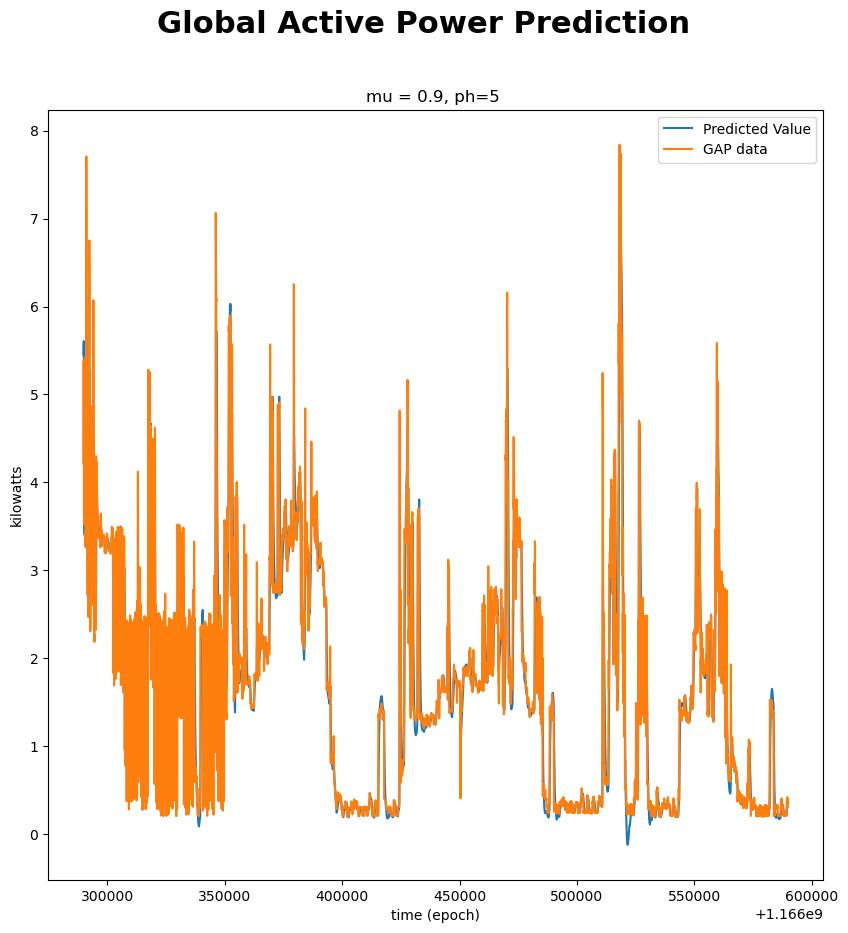

In [323]:
fig, ax = plt.subplots(figsize=(10,10))
fig.suptitle('Global Active Power Prediction', fontsize=22, fontweight='bold')
ax.set_title('mu = %g, ph=%g ' %(mu, ph))
ax.plot(tp_pred, yp_pred, label='Predicted Value') 
ax.plot(ts.iloc[0:n_s,0], ys.iloc[0:n_s,0], label='GAP data') 
ax.set_xlabel('time (epoch)')
ax.set_ylabel('kilowatts')

ax.legend()

It's difficult to tell how the model is performing from this plot.

**TODO: Modify the code above to visualize the first and last 200 datapoints/predictions (can be in separate charts) and compute the MSE for our predictions.**

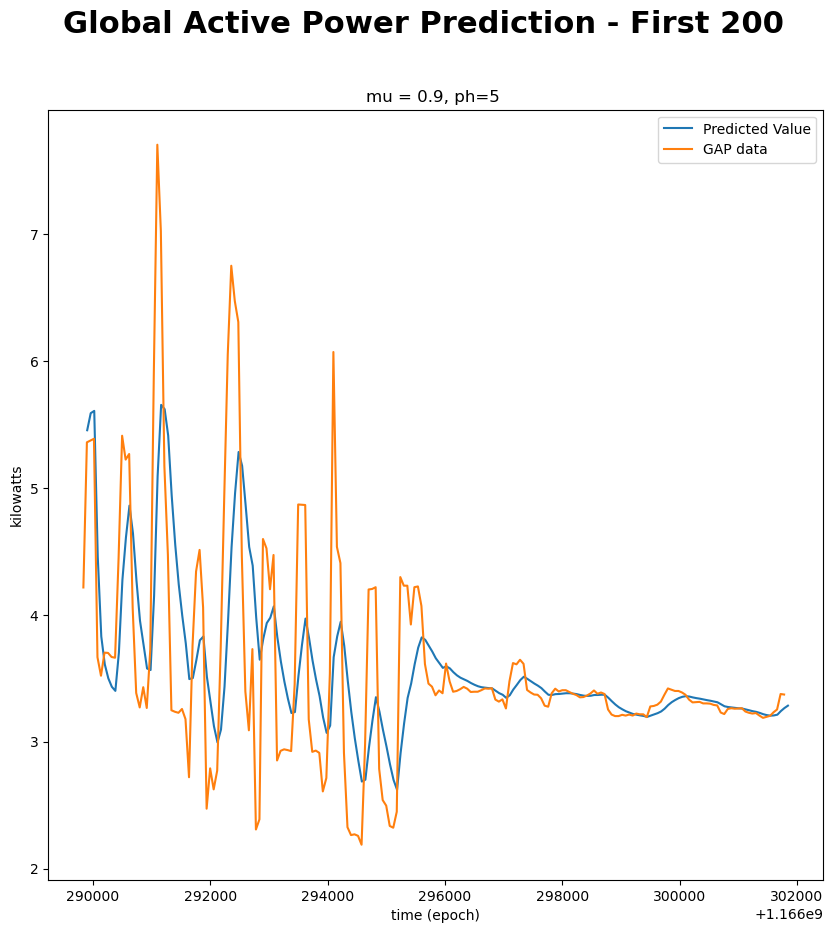

In [324]:
# Plot first 200 data points/predictions
fig, ax = plt.subplots(figsize=(10,10))
fig.suptitle('Global Active Power Prediction - First 200', fontsize=22, fontweight='bold')
ax.set_title('mu = %g, ph=%g ' %(mu, ph))
ax.plot(tp_pred[:200], yp_pred[:200], label='Predicted Value') 
ax.plot(ts.iloc[0:200,0], ys.iloc[0:200,0], label='GAP data') 
ax.set_xlabel('time (epoch)')
ax.set_ylabel('kilowatts')
ax.legend()


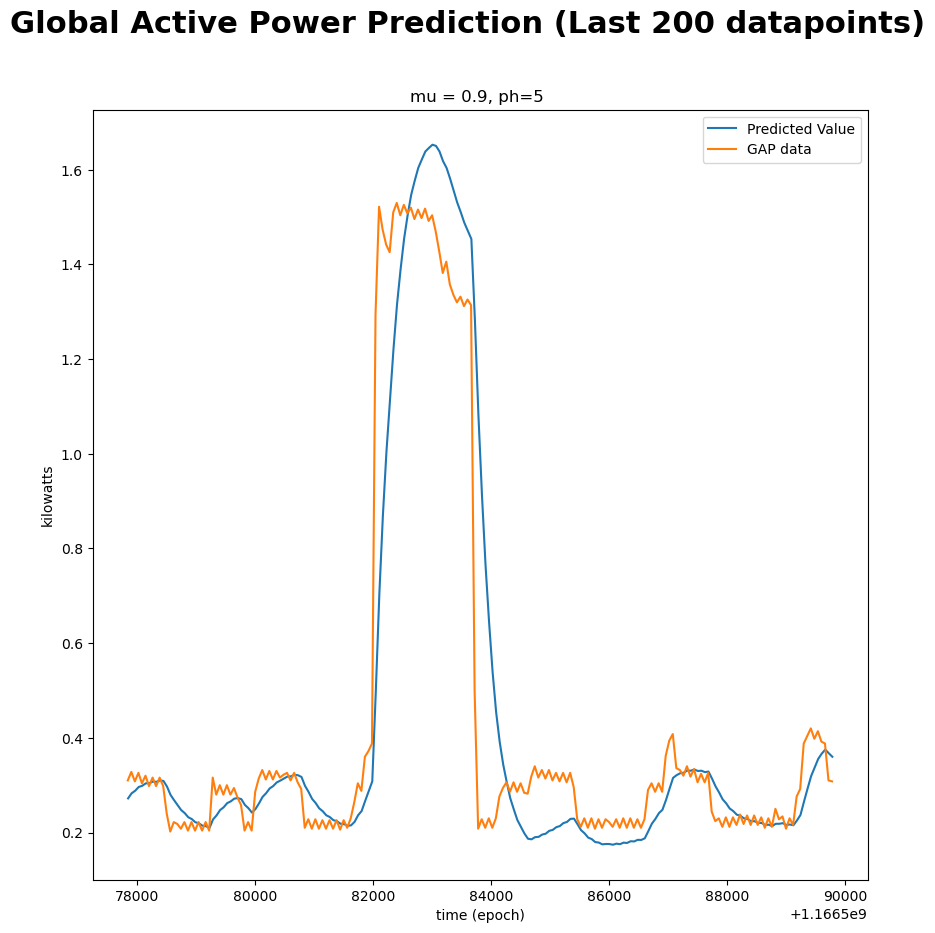

In [325]:
#Plot last 200 data points/predictions
fig, ax = plt.subplots(figsize=(10,10))
fig.suptitle('Global Active Power Prediction (Last 200 datapoints)', fontsize=22, fontweight='bold')
ax.set_title('mu = %g, ph=%g ' %(mu, ph))
ax.plot(tp_pred[-200:], yp_pred[-200:], label='Predicted Value')
ax.plot(ts.iloc[n_s-200:n_s,0], ys.iloc[n_s-200:n_s,0], label='GAP data')
ax.set_xlabel('time (epoch)')
ax.set_ylabel('kilowatts')
ax.legend()

In [326]:
#Calculate MSE of predictions
def mse(y_true, y_pred):
    return np.mean((y_true - y_pred) ** 2)

print("MSE is", mse(ys['Global_active_power'][ph_index:5000+ph_index-1],yp_pred))

MSE is 0.17650896514004885


**Q: How did our model perform? What do you observe on the charts? Is there a difference between the early and the late predictions? What does the MSE tell you?**

A: The prediction value lags slightly behind the actual data, but it is very close to the actual values.
We can also see a significant difference between early and late prediction.
Furthermore, there is a significant difference between the early and late predictions. This could be because the model was trained with a small number of samples, and thus its predictions may become less accurate as it attempts to extrapolate beyond the training data.
The MSE value of **0.176** can be used to calculate the model's prediction error. A lower MSE value indicates better performance, whereas a higher value indicates greater prediction errors. The MSE value alone cannot be used to determine the quality of the model.

**TODO: Re-run the prediction code with mu = 1 and mu = 0.01. Use the cells below to produce charts for the first and last 200 points and to compute the MSE for each of these sets of predictions.**

In [327]:
ts = pd.DataFrame(df.unix)
ys = pd.DataFrame(df.Global_active_power)

ph = 5 #5 minutes
ph_index = int(ph/60)
mu = 1

#let's limit the number of samples in our model to 5000 just for speed
n_s = 5000

tp_pred = np.zeros(n_s-1) 
yp_pred = np.zeros(n_s-1)
for i in range(2, n_s+1):# start out with 2 leading datapoints
    #get x and y data "available" for our prediction
    ts_tmp = ts[0:i]
    ys_tmp = ys[0:i]
    ns = len(ys_tmp)
    
    weights = np.ones(ns)*mu
    for k in range(ns):
        weights[k] = weights[k]**k
    weights = np.flip(weights, 0)
        
    lm_tmp = LinearRegression()
    model_tmp = lm_tmp.fit(ts_tmp, ys_tmp, sample_weight=weights)

    #store model coefficients and intercepts to compute prediction
    m_tmp = model_tmp.coef_
    q_tmp = model_tmp.intercept_

    #use ph to make the model prediction according to the prediction time
    tp = ts.iloc[i-1,0] + ph
    yp = m_tmp * tp + q_tmp

      
    tp_pred[i-2] = tp    
    yp_pred[i-2] = yp


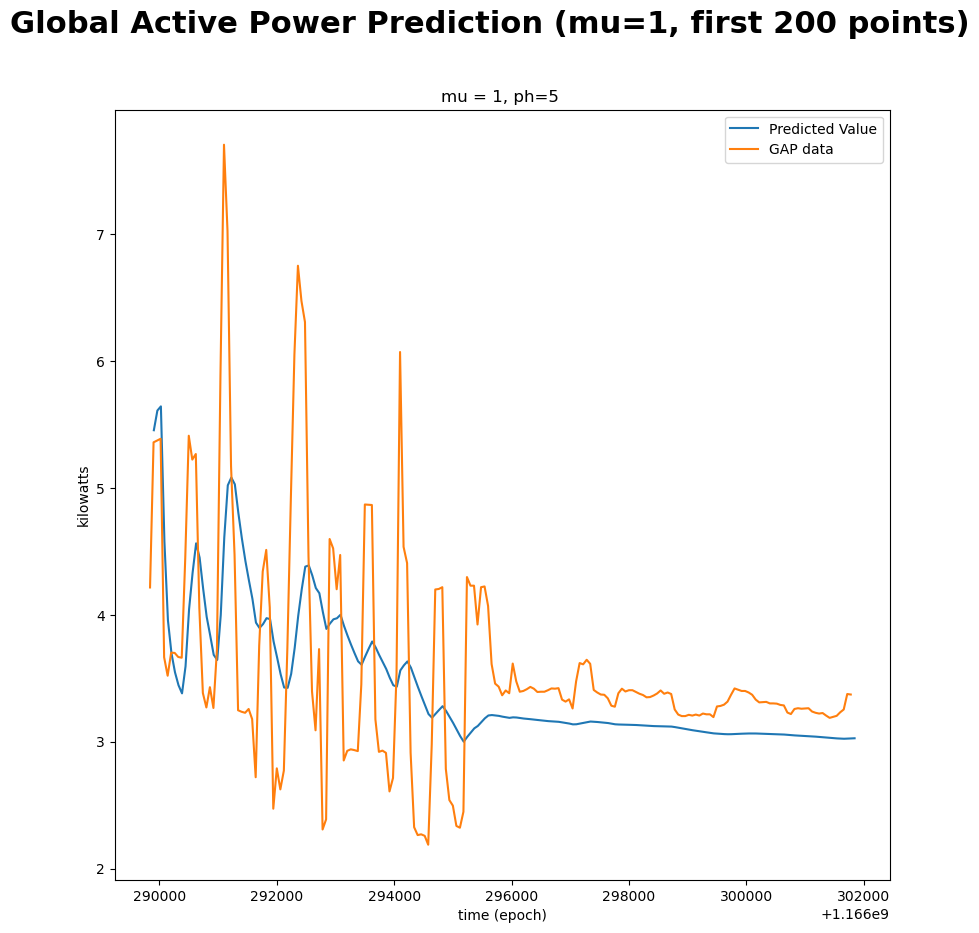

In [328]:
#Plot first 200 data points/predictions for mu = 1
fig, ax = plt.subplots(figsize=(10,10))
fig.suptitle('Global Active Power Prediction (mu=1, first 200 points)', fontsize=22, fontweight='bold')
ax.set_title('mu = %g, ph=%g ' %(1, ph))
ax.plot(tp_pred[:200], yp_pred[:200], label='Predicted Value')
ax.plot(ts.iloc[0:200,0], ys.iloc[0:200,0], label='GAP data')
ax.set_xlabel('time (epoch)')
ax.set_ylabel('kilowatts')
ax.legend()

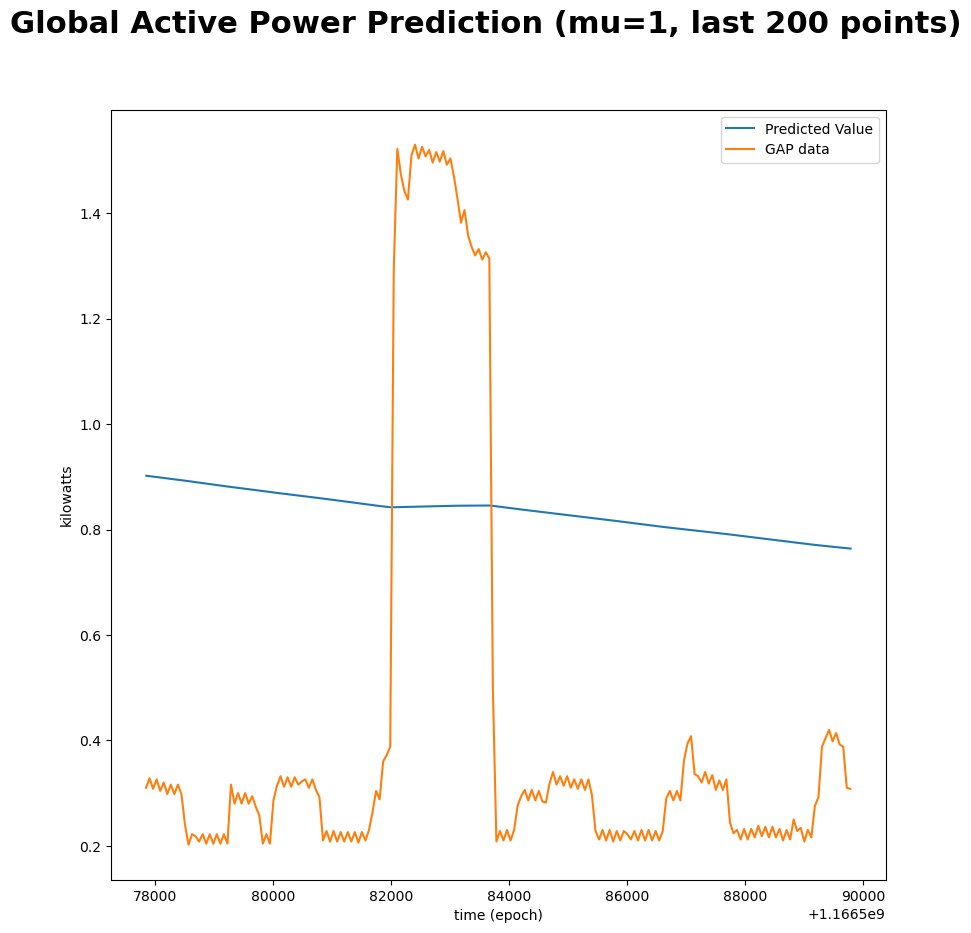

In [329]:
#Plot last 200 data points/predictions for mu = 1
fig, ax = plt.subplots(figsize=(10,10))
fig.suptitle('Global Active Power Prediction (mu=1, last 200 points)', fontsize=22, fontweight='bold')
ax.plot(tp_pred[-200:], yp_pred[-200:], label='Predicted Value')
ax.plot(ts.iloc[n_s-200:n_s,0], ys.iloc[n_s-200:n_s,0], label='GAP data')
ax.set_xlabel('time (epoch)')
ax.set_ylabel('kilowatts')
ax.legend()

In [330]:
#Calculate MSE of predictions for mu = 1
mse_1 = mse(ys['Global_active_power'][ph_index:5000+ph_index-1],yp_pred)
print("MSE is", mse_1)

MSE is 1.3765548530707545


In [331]:
ts = pd.DataFrame(df.unix)
ys = pd.DataFrame(df.Global_active_power)

ph = 5 #5 minutes
ph_index = int(ph/60)#ph/data resolution (how many timesteps is our ph?)
mu = 0.01

#let's limit the number of samples in our model to 5000 just for speed
n_s = 5000

# Arrays to hold predicted values
tp_pred = np.zeros(n_s-1) 
yp_pred = np.zeros(n_s-1)
# At every iteration of the for loop a new data sample is acquired
for i in range(2, n_s+1):# start out with 2 leading datapoints
    #get x and y data "available" for our prediction
    ts_tmp = ts[0:i]
    ys_tmp = ys[0:i]
    ns = len(ys_tmp)
    
    weights = np.ones(ns)*mu
    for k in range(ns):
        #adjust weights to be downweighted according to their timestep away from our prediction
        weights[k] = weights[k]**k
    weights = np.flip(weights, 0)
        
    #perform linear regression on "available" data using the mu-adjusted weights
    lm_tmp = LinearRegression()
    model_tmp = lm_tmp.fit(ts_tmp, ys_tmp, sample_weight=weights)

    #store model coefficients and intercepts to compute prediction
    m_tmp = model_tmp.coef_
    q_tmp = model_tmp.intercept_

    #use ph to make the model prediction according to the prediction time
    tp = ts.iloc[i-1,0] + ph
    yp = m_tmp * tp + q_tmp

      
    tp_pred[i-2] = tp    
    yp_pred[i-2] = yp


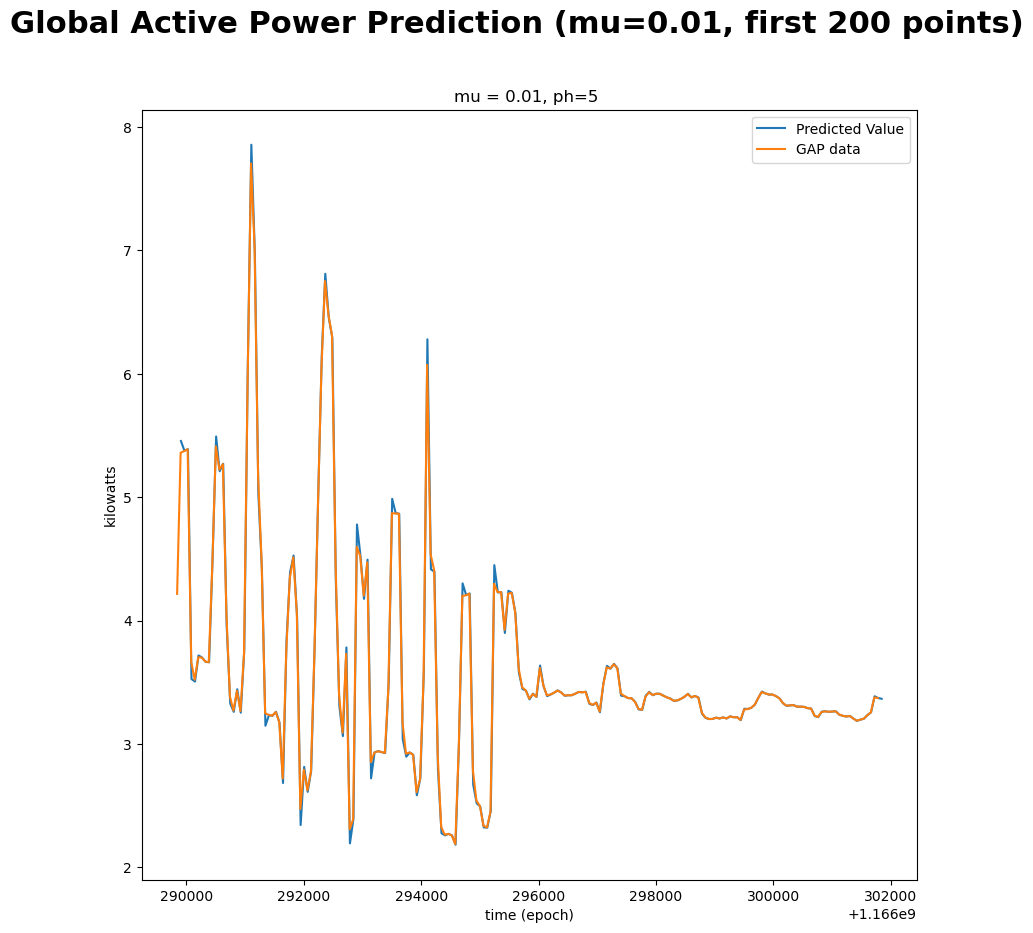

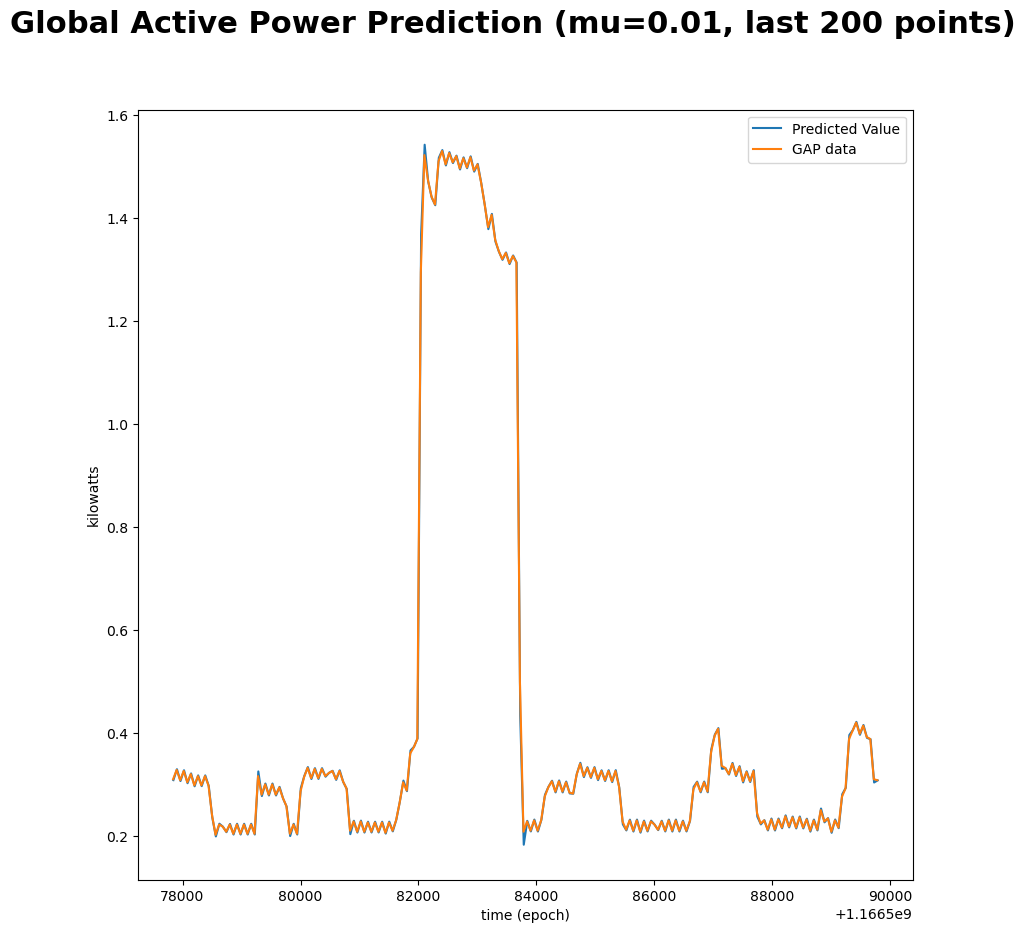

In [332]:
#Plot first 200 data points/predictions for mu = 0.01
fig, ax = plt.subplots(figsize=(10,10))
fig.suptitle('Global Active Power Prediction (mu=0.01, first 200 points)', fontsize=22, fontweight='bold')
ax.set_title('mu = %g, ph=%g ' %(0.01, ph))
ax.plot(tp_pred[:200], yp_pred[:200], label='Predicted Value')
ax.plot(ts.iloc[0:200,0], ys.iloc[0:200,0], label='GAP data')
ax.set_xlabel('time (epoch)')
ax.set_ylabel('kilowatts')
ax.legend()

#Plot last 200 data points/predictions for mu = 0.01
fig, ax = plt.subplots(figsize=(10,10))
fig.suptitle('Global Active Power Prediction (mu=0.01, last 200 points)', fontsize=22, fontweight='bold')
ax.plot(tp_pred[-200:], yp_pred[-200:], label='Predicted Value')
ax.plot(ts.iloc[n_s-200:n_s,0], ys.iloc[n_s-200:n_s,0], label='GAP data')
ax.set_xlabel('time (epoch)')
ax.set_ylabel('kilowatts')
ax.legend()


In [333]:
# Calculate MSE of predictions for mu = 0.01
print("MSE for mu = 0.01 is", mse(ys['Global_active_power'][ph_index:5000+ph_index-1],yp_pred))


MSE for mu = 0.01 is 0.2922694586368877


**Q: How did our mu = 1 model perform? What do you observe on the charts? Is there a difference between the early and the late predictions? What does the MSE tell you?**

A: When mu = 1, we can see that the predicted and actual values in graphs vary considerably, implying that increasing the mse values worsens the prediction.

**Q: How did our mu = 0.01 model perform? What do you observe on the charts? Is there a difference between the early and the late predictions? What does the MSE tell you?**

A: The prediction value corresponds to the actual data, implying that the model with a mu value of 0.01 performed well. The MSE of 0.292 indicates that the model's predictions are reasonably accurate because the MSE is low.


**Q: Which of these three models is the best? How do you know? Why does this make sense based on the mu parameter used?**

A: Based solely on the MSE values provided, it appears that the model with mu = 0.9 has the lowest MSE of 0.1765, indicating that it outperforms the other two models.
The best model is determined by the specific problem and the application's requirements.However, assuming that the problem requires minimizing the MSE, the model with mu = 0.9.


**Q: What could we do to improve our model and/or make it more realistic and useful?**

A: There are ways to improve a model and make it more realistic and useful like the process of selecting, creating, and transforming features in a dataset to improve the performance of a machine learning model is known as feature engineering. The model can be more accurate and perform better by selecting or creating better features that are more relevant to the problem.

**TODO: Add voltage data as a second variable to our model and re-run the prediction code. Then visualize the first and last 200 points and compute the MSE**

In [334]:
#add voltage to the x-variables in our dataset
ts = pd.DataFrame(df.unix)
ys = pd.DataFrame(df.Voltage)

ph = 5 #5 minutes
ph_index = int(60/ph)
mu = 0.9

#let's limit the number of samples in our model to 5000 just for speed
n_s = 5000

#arrays to hold predicted values
tp_pred = np.zeros(n_s-1) 
yp_pred = np.zeros(n_s-1)

In [336]:
#run the prediction code on your expanded dataset

for i in range(2, n_s+1):# start out with 2 leading datapoints
    #get x and y data "available" for our prediction
    ts_tmp = ts[0:i]
    ys_tmp = ys[0:i]
    ns = len(ys_tmp)
    
    weights = np.ones(ns)*mu
    for k in range(ns):
        #adjust weights to be downweighted according to their timestep away from our prediction
        weights[k] = weights[k]**k
    weights = np.flip(weights, 0)
        
    #perform linear regression on "available" data using the mu-adjusted weights
    lm_tmp = LinearRegression()
    model_tmp = lm_tmp.fit(ts_tmp, ys_tmp, sample_weight=weights)

    #store model coefficients and intercepts to compute prediction
    m_tmp = model_tmp.coef_
    q_tmp = model_tmp.intercept_

    #use ph to make the model prediction according to the prediction time
    tp = ts.iloc[i-1,0] + ph
    yp = m_tmp * tp + q_tmp

      
    tp_pred[i-2] = tp    
    yp_pred[i-2] = yp



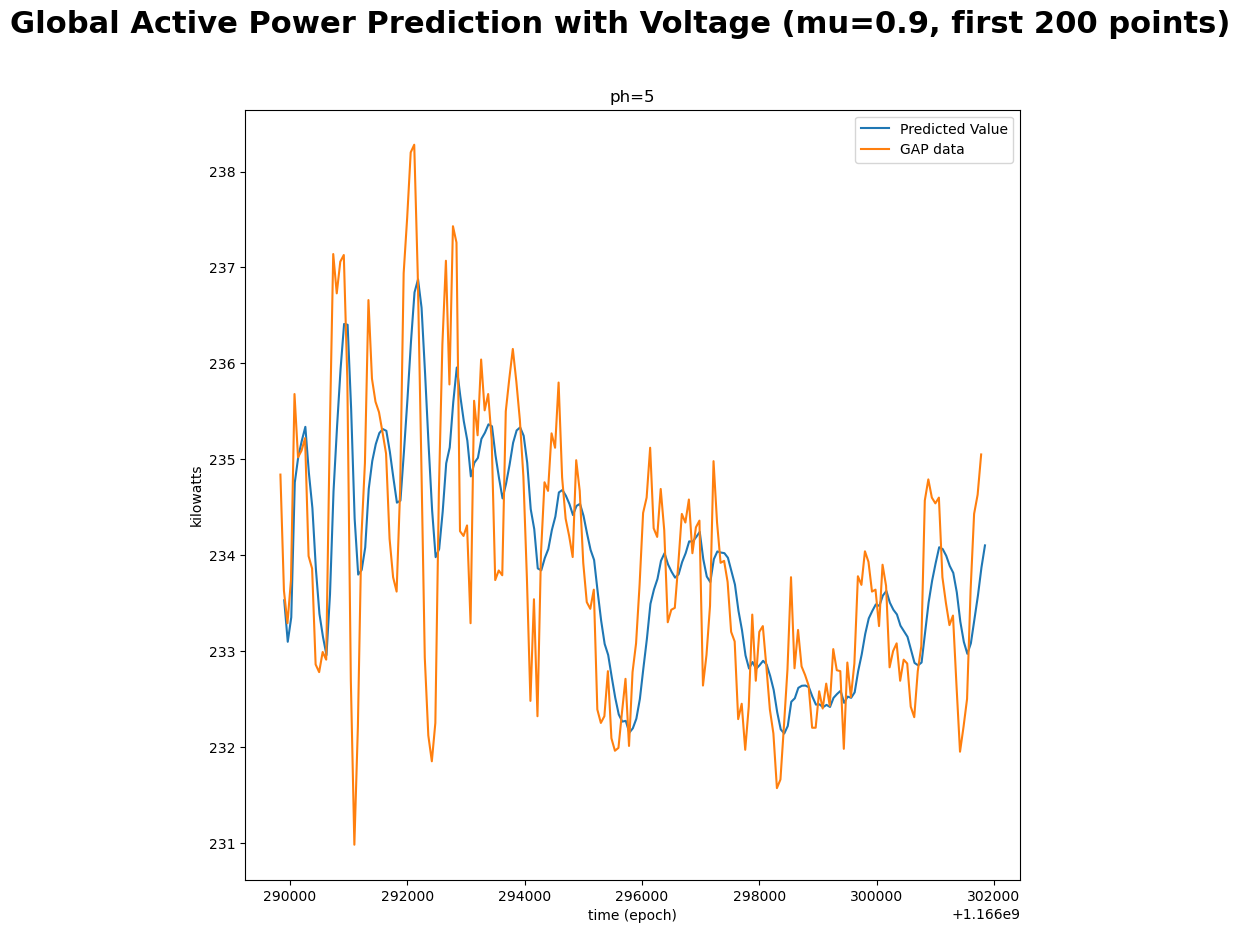

In [337]:
#Plot first 200 data points/predictions for the expanded dataset
fig, ax = plt.subplots(figsize=(10,10))
fig.suptitle('Global Active Power Prediction with Voltage (mu=0.9, first 200 points)', fontsize=22, fontweight='bold')
ax.set_title('ph=%g' %ph)
ax.plot(tp_pred[:200], yp_pred[:200], label='Predicted Value')
ax.plot(ts.iloc[0:200,0], ys.iloc[0:200,0], label='GAP data')
ax.set_xlabel('time (epoch)')
ax.set_ylabel('kilowatts')
ax.legend()

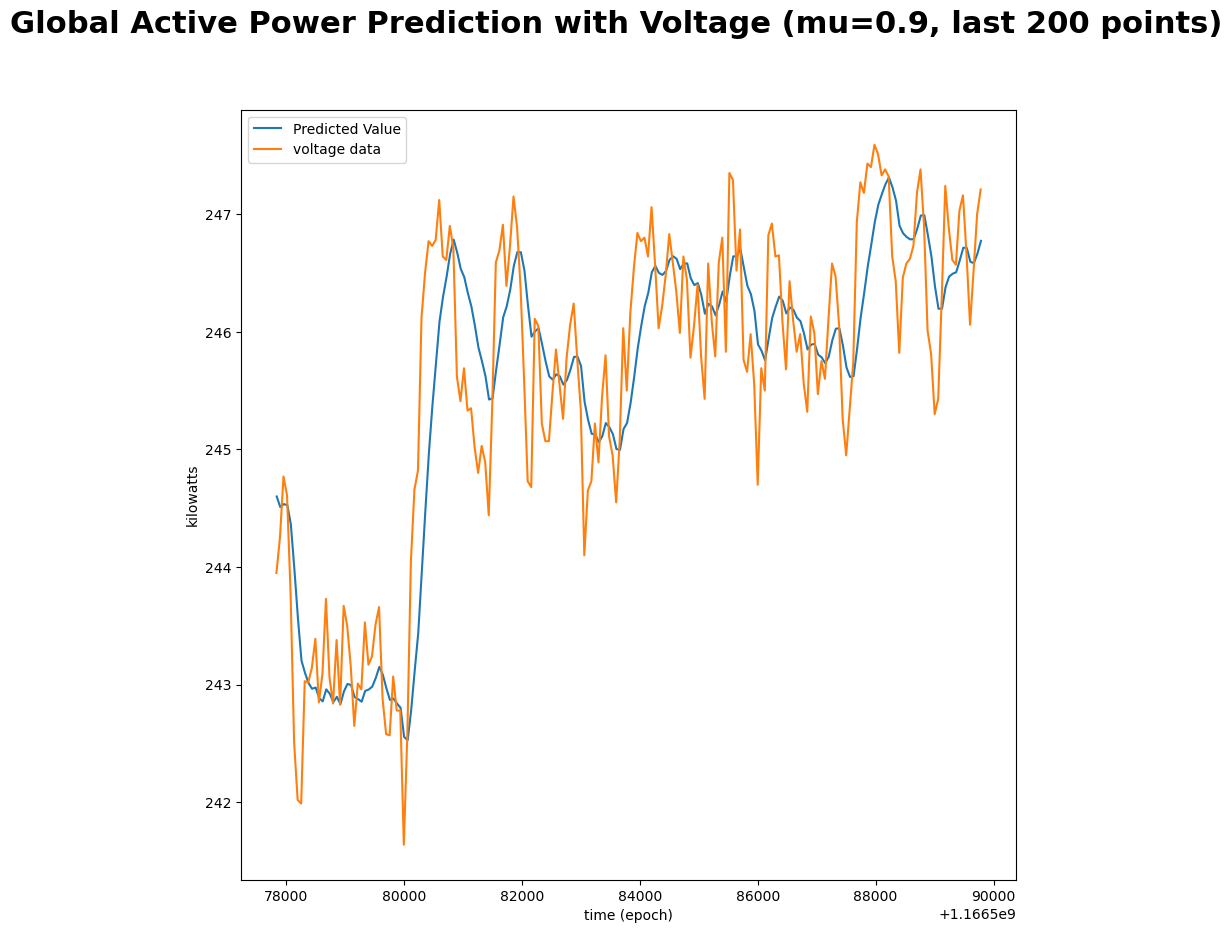

In [338]:
#Plot last 200 data points/predictions for the expanded dataset
fig, ax = plt.subplots(figsize=(10,10))
fig.suptitle('Global Active Power Prediction with Voltage (mu=0.9, last 200 points)', fontsize=22, fontweight='bold')
ax.plot(tp_pred[-200:], yp_pred[-200:], label='Predicted Value')
ax.plot(ts.iloc[n_s-200:n_s,0], ys.iloc[n_s-200:n_s,0], label='voltage data')
ax.set_xlabel('time (epoch)')
ax.set_ylabel('kilowatts')
ax.legend()

In [343]:
#Calculate MSE of predictions for the expanded dataset
mse_exp = mse(ys['Voltage'][ph_index:5000+ph_index-1],yp_pred)
print("MSE is", mse_exp)


MSE is 3.6265534073024543


**Q: How did the model performed when you added the voltage data? How does it compare to the models without it?**

A: The model with the added voltage data had a higher MSE of 3.63 compared to the models without it. This suggests that adding the voltage data did not necessarily improve the model's performance, and may have even made it worse.

There are lots of other ways that we could try to improve our model while still using linear regression.

**TODO: Choose one alternative model and re-run the prediction code. Some ideas include:**

- Use a moving average as the response variable
- Make your prediction based on the time of day instead of as a continuous time series
- Use a moving window to limit your predictions instead of using a mu factor

**Q: Describe your alternative model and why it might improve your model**

A: Instead of a fixed mu factor, I propose using a moving window to limit our predictions in this alternative model. This method has the potential to capture more variability in the data and increase the flexibility of our predictions.
Instead of using a fixed mu factor to weight the previous observation, we will predict the next one using a rolling window of previous observations. This means that the model will be more responsive to changes in the data and will not be constrained by a fixed weight.

In [344]:
# create your alternative training data here
n = 10 # window size for moving average
ys_ma = ys.rolling(n).mean()[n-1:]

# set ph and ph_index as before
ph = 5 # minutes
ph_index = int(ph / (1/60))

mu = 0.9

n_s = 5000

# arrays to hold predicted values
tp_pred = np.zeros(n_s-1) 
yp_pred = np.zeros(n_s-1)

In [354]:
# calculate mean squared error of predictions for alternative model
for i in range(n_s-1):
    if i == 0:
        #initialize the first predicted value to the first true value
        yp_pred[i] = ys_ma.iloc[i,0]
    else:
        #predict the next value using the current value and mu
        tp_pred[i] = ts.iloc[i,0] + ph
        yp_pred[i] = mu * ys_ma.iloc[i-1,0] + (1-mu) * yp_pred[i-1]

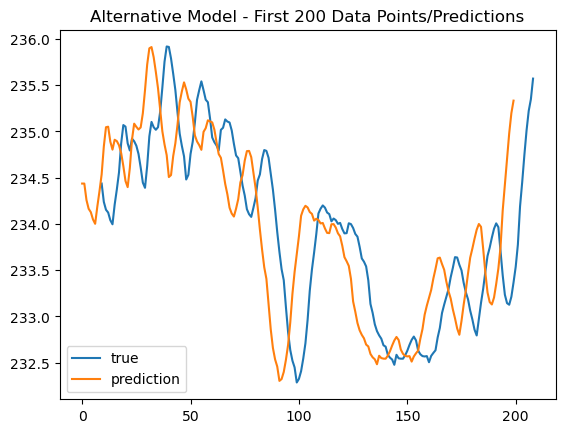

In [356]:
plt.plot(ys_ma.iloc[:200,:], label='true')
plt.plot(yp_pred[:200], label='prediction')
plt.legend()
plt.title('Alternative Model - First 200 Data Points/Predictions')
plt.show()

In [358]:
#Calculate MSE of predictions for alternative model
mse_alt = mean_squared_error(tp_pred, yp_pred)
print("MSE of Alternative Model: ", mse_alt)

MSE of Alternative Model:  1.3603091166407352e+18


**Q: Did your alternative model improve on our previous results? What else could you do to improve the model while still using linear regression?**

A:The alternative model using a moving average as the response variable did not improve on the previous results.
One other thing we could do to improve the model while still using linear regression is to use polynomial regression instead. Polynomial regression allows us to model non-linear relationships between the predictor variables and the response variable. We could also try feature engineering, such as creating interaction terms between the predictor variables, to capture any non-linear relationships that may exist.

It's worth noting that the results we're getting int his assignment are based on a pretty short predictive horizon of 5 minutes. If we were to increase our predictive horizon, our results would likely be worse and there would be more room for optimizing and improving the predictions of our model.